In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import os
from scipy.linalg import circulant
from numpy import linalg as LA
import preprocess as pr
from keras.preprocessing import sequence
import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Input,Conv1D,MaxPooling1D,Flatten,LSTM,Dropout,BatchNormalization,Activation,Concatenate
import hickle as hkl
from keras.preprocessing import sequence
import re
from sklearn import preprocessing

In [3]:
os.chdir("/Polycarbon/hand Motion Clasification")

In [4]:
def read_in_folder(folder_path,gesture_name):
    x=[]
    y=[]
    for file in os.listdir(folder_path):
        if( "-L-" in file): 
            L_hand_file=  folder_path +"/"+file
            R_hand_file=  folder_path +"/"+ re.sub(r"-L-","-R-",file)
            dL=pr.read_emg(L_hand_file).dropna().astype(float)
            dR=pr.read_emg(R_hand_file).dropna().astype(float)
            if(gesture_name!="1"):
                if(dL.Time.size>900):
                    T1 =  pr.find_active_time(dL.Time,dL.loc[:,['gx','gy','gz']])
                    T2 =  pr.find_active_time(dR.Time,dR.loc[:,['gx','gy','gz']])
                    if (len(T1)==2):
                        T = (np.array(T1)+np.array(T2))/2
                        Lhand = dL[dL.Time>=T[0]].T.values[1:]
                        Rhand = dR[dR.Time>=T[0]].T.values[1:]
                        x.append([Lhand,Rhand])
                        y.append(gesture_name)
            else:
                Lhand = dL.T.values[1:]
                Rhand = dR.T.values[1:]
                x.append([Lhand,Rhand])
                y.append(gesture_name)
            #print("success :"+L_hand_file+"__"+R_hand_file)
    return x,y

for n,sample in enumerate(os.listdir("Data/")):
    x = []
    y = []
    if(os.path.isdir("Data/"+sample) and sample!=".ipynb_checkpoints"):
        for i in range(1,16):
            filename = "M"+str(i)+"-"+sample  
            if len(os.listdir("Data/"+sample+"/"+filename))==2:
                for fd in os.listdir("Data/"+sample+"/"+filename):
                    filepath="Data/"+sample+"/"+filename+"/"+fd+"/"
                    u,v = read_in_folder(filepath,str(i)+fd.lower())
                    x.extend(u)
                    y.extend(v)
            else:
                filepath="Data/"+sample+"/"+filename
                u,v = read_in_folder(filepath,str(i))
                x.extend(u)
                y.extend(v)
    data = {"data":x,"label":y}
    hkl.dump( data, "Trimed data/"+sample+".hkl")
    print("success"+sample+".hkl")

In [ ]:
sample="Gulthida"
x = []
y = []
if(os.path.isdir("Data/"+sample) and sample!=".ipynb_checkpoints"):
    for i in range(1,16):
        filename = "M"+str(i)+"-"+sample  
        if len(os.listdir("Data/"+sample+"/"+filename))==2:
            for fd in os.listdir("Data/"+sample+"/"+filename):
                filepath="Data/"+sample+"/"+filename+"/"+fd+"/"
                u,v = read_in_folder(filepath,str(i)+fd.lower())
                x.extend(u)
                y.extend(v)
        else:
            filepath="Data/"+sample+"/"+filename
            u,v = read_in_folder(filepath,str(i))
            x.extend(u)
            y.extend(v)
data = {"data":x,"label":y}
hkl.dump( data, "Trimed data/"+sample+".hkl")
print("success"+sample+".hkl")

# build model function

In [3]:
def build_model(feature_length,window_length):
    input_signal = Input(shape=(feature_length,window_length),name="input_signal")
    x = Conv1D(filters=32, kernel_size=3,activation='relu', padding='same')(input_signal)
    #x = BatchNormalization()(x)
    x = MaxPooling1D(2, padding='same')(x)
    x = Conv1D(filters=16, kernel_size=200,activation='relu', padding='same')(x)
    #x = BatchNormalization()(x)
    x = MaxPooling1D(2, padding='same')(x)
    x = Conv1D(filters=8, kernel_size=200,activation='relu', padding='same')(x)
    #x = BatchNormalization()(x)
    x = MaxPooling1D(2, padding='same')(x)
    x = Flatten()(x)
   # x = Dropout(0.5)(x)
    x = Dense(output_dim = 80, init = 'uniform', activation = 'relu')(x)
    dense_out = Dense(17, activation="sigmoid" ,name ="output_Dense")(x)
    
    model=Model(inputs=[input_signal], outputs=[dense_out])
        
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def build_model2(window_length,feature_length):
    input_signal = Input(shape=(window_length,feature_length),name="input_signal")
    x = Conv1D(filters=32, kernel_size=3,activation='relu', padding='same')(input_signal)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2, padding='same')(x)
    x = Conv1D(filters=16, kernel_size=200,activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2, padding='same')(x)
    x = Conv1D(filters=8, kernel_size=200,activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2, padding='same')(x)

    x = Flatten()(x)
   # x = Dropout(0.5)(x)
    x = Dense(output_dim = 80, init = 'uniform', activation = 'relu')(x)
    dense_out = Dense(17, activation="sigmoid" ,name ="output_Dense")(x)
    
    model=Model(inputs=[input_signal], outputs=[dense_out])
        
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# evaluation

เพิ่มข้อมูลไปที่ละ10คนแล้วบันทึก acc. ที่ได้

In [1]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold,StratifiedKFold

Using TensorFlow backend.


In [5]:
seed = 7
np.random.seed(seed)

# 10 sample

In [ ]:
x=[]
y=[]
for sample_file in os.listdir("Trimed data/")[:10]:
    d= hkl.load("Trimed data/"+sample_file)
    x.extend(d["data"])
    y.extend(d["label"])
    print("success : "+sample_file)
    
encoder = preprocessing.LabelEncoder()
encoder.fit(y)
y_e = encoder.transform(y)
lenghts = [len(x[i][0][0]) for i in range(len(x))]
x=[x[i] for i,l in enumerate(lenghts) if(l>900 and l<3000)]
y_e =[y_e [i] for i,l in enumerate(lenghts) if(l>900 and l<3000)]

success : Amnoey.hkl
success : amnuay.hkl
success : ampai2.hkl
success : angkana.hkl


In [127]:
XL=np.array([sequence.pad_sequences(b[0], padding="post",maxlen=2000,dtype='float32')for b in x])
XR=np.array([sequence.pad_sequences(b[1], padding="post",maxlen=2000,dtype='float32')for b in x])
X =np.concatenate((XL[:,16:], XR[:,16:]), axis=1)

In [ ]:
from sklearn.preprocessing import normalize
y_e = np.array(y_e)
for gt in range(encoder.classes_.size):
    for ch in range(len(X[0])):      
        X[y_e==gt][:,ch] = normalize(X[y_e==gt][:,ch])

In [11]:
estimator = KerasClassifier(build_fn=build_model2,feature_length=X.shape[2]  ,window_length=X.shape[1],epochs=100, batch_size=500, verbose=1)
skf = StratifiedKFold(n_splits=10,shuffle=True, random_state=seed)
results10 = cross_val_score(estimator, X, y_e , cv=skf)
print("Baseline: %.2f%% (%.2f%%)" % (results10.mean()*100, results10.std()*100))

C:\Users\Denice\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:36: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=80, kernel_initializer="uniform")`


Epoch 1/100
1469/1469 [==============================] - 1s 786us/step - loss: 2.8167 - acc: 0.0769
Epoch 2/100
1469/1469 [==============================] - 0s 198us/step - loss: 2.7720 - acc: 0.1409
Epoch 3/100
1469/1469 [==============================] - 0s 200us/step - loss: 2.7245 - acc: 0.2314
Epoch 4/100
1469/1469 [==============================] - 0s 201us/step - loss: 2.6793 - acc: 0.2975
Epoch 5/100
1469/1469 [==============================] - 0s 203us/step - loss: 2.6284 - acc: 0.3506 0s - loss: 2.6344 - acc: 0.339
Epoch 6/100
1469/1469 [==============================] - 0s 204us/step - loss: 2.5744 - acc: 0.3975
Epoch 7/100
1469/1469 [==============================] - 0s 198us/step - loss: 2.5140 - acc: 0.4316
Epoch 8/100
1469/1469 [==============================] - 0s 200us/step - loss: 2.4472 - acc: 0.4942
Epoch 9/100
1469/1469 [==============================] - 0s 200us/step - loss: 2.3733 - acc: 0.5344
Epoch 10/100
1469/1469 [==============================] - 0s 197us/st

Epoch 81/100
1469/1469 [==============================] - 0s 199us/step - loss: 0.0054 - acc: 1.0000 0s - loss: 0.0054 - acc: 1.000
Epoch 82/100
1469/1469 [==============================] - 0s 196us/step - loss: 0.0052 - acc: 1.0000
Epoch 83/100
1469/1469 [==============================] - 0s 200us/step - loss: 0.0052 - acc: 1.0000
Epoch 84/100
1469/1469 [==============================] - 0s 200us/step - loss: 0.0049 - acc: 1.0000
Epoch 85/100
1469/1469 [==============================] - 0s 200us/step - loss: 0.0048 - acc: 1.0000
Epoch 86/100
1469/1469 [==============================] - 0s 200us/step - loss: 0.0047 - acc: 1.0000
Epoch 87/100
1469/1469 [==============================] - 0s 198us/step - loss: 0.0047 - acc: 1.0000
Epoch 88/100
1469/1469 [==============================] - 0s 198us/step - loss: 0.0046 - acc: 1.0000
Epoch 89/100
1469/1469 [==============================] - 0s 201us/step - loss: 0.0045 - acc: 1.0000
Epoch 90/100
1469/1469 [==============================] - 0s

1471/1471 [==============================] - 0s 202us/step - loss: 0.0086 - acc: 1.0000
Epoch 62/100
1471/1471 [==============================] - 0s 199us/step - loss: 0.0085 - acc: 1.0000 0s - loss: 0.0083 - acc: 1.000
Epoch 63/100
1471/1471 [==============================] - 0s 196us/step - loss: 0.0080 - acc: 1.0000
Epoch 64/100
1471/1471 [==============================] - 0s 199us/step - loss: 0.0077 - acc: 1.0000
Epoch 65/100
1471/1471 [==============================] - 0s 197us/step - loss: 0.0075 - acc: 1.0000
Epoch 66/100
1471/1471 [==============================] - 0s 197us/step - loss: 0.0074 - acc: 1.0000
Epoch 67/100
1471/1471 [==============================] - 0s 199us/step - loss: 0.0070 - acc: 1.0000
Epoch 68/100
1471/1471 [==============================] - 0s 197us/step - loss: 0.0068 - acc: 1.0000
Epoch 69/100
1471/1471 [==============================] - 0s 198us/step - loss: 0.0066 - acc: 1.0000
Epoch 70/100
1471/1471 [==============================] - 0s 197us/step -

1471/1471 [==============================] - 0s 201us/step - loss: 0.7417 - acc: 0.9667
Epoch 21/100
1471/1471 [==============================] - 0s 206us/step - loss: 0.6065 - acc: 0.9721
Epoch 22/100
1471/1471 [==============================] - 0s 199us/step - loss: 0.4938 - acc: 0.9816
Epoch 23/100
1471/1471 [==============================] - 0s 197us/step - loss: 0.3895 - acc: 0.9912
Epoch 24/100
1471/1471 [==============================] - 0s 201us/step - loss: 0.3131 - acc: 0.9952
Epoch 25/100
1471/1471 [==============================] - 0s 199us/step - loss: 0.2477 - acc: 0.9952
Epoch 26/100
1471/1471 [==============================] - 0s 198us/step - loss: 0.1999 - acc: 0.9986
Epoch 27/100
1471/1471 [==============================] - 0s 203us/step - loss: 0.1581 - acc: 0.9986
Epoch 28/100
1471/1471 [==============================] - 0s 200us/step - loss: 0.1259 - acc: 0.9993
Epoch 29/100
1471/1471 [==============================] - 0s 203us/step - loss: 0.1030 - acc: 0.9993
Epo

1471/1471 [==============================] - 0s 202us/step - loss: 0.0052 - acc: 1.0000
Epoch 81/100
1471/1471 [==============================] - 0s 201us/step - loss: 0.0051 - acc: 1.0000
Epoch 82/100
1471/1471 [==============================] - 0s 201us/step - loss: 0.0049 - acc: 1.0000
Epoch 83/100
1471/1471 [==============================] - 0s 202us/step - loss: 0.0048 - acc: 1.0000
Epoch 84/100
1471/1471 [==============================] - 0s 199us/step - loss: 0.0047 - acc: 1.0000
Epoch 85/100
1471/1471 [==============================] - 0s 201us/step - loss: 0.0046 - acc: 1.0000
Epoch 86/100
1471/1471 [==============================] - 0s 200us/step - loss: 0.0045 - acc: 1.0000
Epoch 87/100
1471/1471 [==============================] - 0s 200us/step - loss: 0.0044 - acc: 1.0000
Epoch 88/100
1471/1471 [==============================] - 0s 201us/step - loss: 0.0043 - acc: 1.0000
Epoch 89/100
1471/1471 [==============================] - 0s 200us/step - loss: 0.0042 - acc: 1.0000
Epo

1472/1472 [==============================] - 0s 198us/step - loss: 0.0264 - acc: 1.0000
Epoch 40/100
1472/1472 [==============================] - 0s 197us/step - loss: 0.0239 - acc: 1.0000
Epoch 41/100
1472/1472 [==============================] - 0s 196us/step - loss: 0.0220 - acc: 1.0000
Epoch 42/100
1472/1472 [==============================] - 0s 199us/step - loss: 0.0203 - acc: 1.0000
Epoch 43/100
1472/1472 [==============================] - 0s 199us/step - loss: 0.0187 - acc: 1.0000
Epoch 44/100
1472/1472 [==============================] - 0s 198us/step - loss: 0.0173 - acc: 1.0000
Epoch 45/100
1472/1472 [==============================] - 0s 197us/step - loss: 0.0162 - acc: 1.0000
Epoch 46/100
1472/1472 [==============================] - 0s 201us/step - loss: 0.0152 - acc: 1.0000
Epoch 47/100
1472/1472 [==============================] - 0s 201us/step - loss: 0.0146 - acc: 1.0000
Epoch 48/100
1472/1472 [==============================] - 0s 199us/step - loss: 0.0135 - acc: 1.0000
Epo

1475/1475 [==============================] - 0s 205us/step - loss: 0.0033 - acc: 1.0000
Epoch 99/100
1475/1475 [==============================] - 0s 200us/step - loss: 0.0033 - acc: 1.0000
Epoch 100/100
162/162 [==============================] - 0s 3ms/step
Epoch 1/100
1478/1478 [==============================] - 2s 1ms/step - loss: 2.8261 - acc: 0.0737
Epoch 2/100
1478/1478 [==============================] - 0s 196us/step - loss: 2.7807 - acc: 0.1543
Epoch 3/100
1478/1478 [==============================] - 0s 194us/step - loss: 2.7317 - acc: 0.2693
Epoch 4/100
1478/1478 [==============================] - 0s 196us/step - loss: 2.6813 - acc: 0.3383
Epoch 5/100
1478/1478 [==============================] - 0s 196us/step - loss: 2.6315 - acc: 0.3863
Epoch 6/100
1478/1478 [==============================] - 0s 197us/step - loss: 2.5781 - acc: 0.4635
Epoch 7/100
1478/1478 [==============================] - 0s 197us/step - loss: 2.5208 - acc: 0.5318
Epoch 8/100
1478/1478 [=====================

1484/1484 [==============================] - 0s 202us/step - loss: 0.0108 - acc: 1.0000
Epoch 57/100
1484/1484 [==============================] - 0s 200us/step - loss: 0.0107 - acc: 1.0000
Epoch 58/100
1484/1484 [==============================] - 0s 198us/step - loss: 0.0100 - acc: 1.0000
Epoch 59/100
1484/1484 [==============================] - 0s 198us/step - loss: 0.0098 - acc: 1.0000
Epoch 60/100
1484/1484 [==============================] - 0s 199us/step - loss: 0.0092 - acc: 1.0000
Epoch 61/100
1484/1484 [==============================] - 0s 200us/step - loss: 0.0089 - acc: 1.0000
Epoch 62/100
1484/1484 [==============================] - 0s 201us/step - loss: 0.0086 - acc: 1.0000
Epoch 63/100
1484/1484 [==============================] - 0s 200us/step - loss: 0.0083 - acc: 1.0000
Epoch 64/100
1484/1484 [==============================] - 0s 198us/step - loss: 0.0081 - acc: 1.0000
Epoch 65/100
1484/1484 [==============================] - 0s 201us/step - loss: 0.0078 - acc: 1.0000
Epo

In [139]:
print(results10)
print("Baseline: %.2f%% (%.2f%%)" % (results10.mean()*100, results10.std()*100))

[0.95 0.98 0.94 0.95 0.98 0.95 0.96 0.95 0.89 0.94]
Baseline: 94.78% (2.43%)


In [12]:
print(results10)
print("Baseline: %.2f%% (%.2f%%)" % (results10.mean()*100, results10.std()*100))

[0.9464286  0.96987951 0.93373495 0.94578314 0.93975902 0.98192769
 0.92727274 0.95679015 0.89937109 0.94771242]
Baseline: 94.49% (2.16%)


# 20 sample

In [13]:
x=[]
y=[]
for sample_file in os.listdir("Trimed data/")[:20]:
    d= hkl.load("Trimed data/"+sample_file)
    x.extend(d["data"])
    y.extend(d["label"])
    print("success : "+sample_file)
    
encoder = preprocessing.LabelEncoder()
encoder.fit(y)
y_e  = encoder.transform(y)
lenghts = [len(x[i][0][0]) for i in range(len(x))]
x=[x[i] for i,l in enumerate(lenghts) if(l>900 and l<3000)]
y_e =[y_e [i] for i,l in enumerate(lenghts) if(l>900 and l<3000)]

success : Amnoey.hkl
success : amnuay.hkl
success : ampai2.hkl
success : angkana.hkl
success : Aphinop.hkl
success : Aueporn.hkl
success : Bancha.hkl
success : Benjarat.hkl
success : Boonching.hkl
success : Buntean.hkl
success : Buntra.hkl
success : Charuves_Krasaerot.hkl
success : Chatri.hkl
success : Donsatid.hkl
success : Duangporn.hkl
success : Duenpen.hkl
success : dusid.hkl
success : Jamroen.hkl
success : Jamroen_Murangkerd.hkl
success : Jinda_Jaichuphan.hkl


In [14]:
XL=np.array([sequence.pad_sequences(b[0], padding="post",maxlen=2000,dtype='float32')for b in x])
XR=np.array([sequence.pad_sequences(b[1], padding="post",maxlen=2000,dtype='float32')for b in x])
X =np.concatenate((XL[:,16:], XR[:,16:]), axis=1)

In [15]:
from sklearn.preprocessing import normalize
y_e = np.array(y_e)
for gt in range(encoder.classes_.size):
    for ch in range(len(X[0])):      
        X[y_e==gt][:,ch] = normalize(X[y_e==gt][:,ch])

In [17]:
estimator = KerasClassifier(build_fn=build_model2,feature_length=X.shape[2]  ,window_length=X.shape[1],epochs=100, batch_size=500, verbose=1)
skf = StratifiedKFold(n_splits=10,shuffle=True, random_state=seed)
skf.get_n_splits(X, y_e)
results20 = cross_val_score(estimator, X, y_e, cv=skf)

C:\Users\Denice\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:36: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=80, kernel_initializer="uniform")`


Epoch 1/100
2686/2686 [==============================] - 3s 1ms/step - loss: 2.8119 - acc: 0.0797
Epoch 2/100
2686/2686 [==============================] - 1s 204us/step - loss: 2.7428 - acc: 0.1981 0s - loss: 2.7590 - acc: 0.
Epoch 3/100
2686/2686 [==============================] - 1s 204us/step - loss: 2.6719 - acc: 0.2729
Epoch 4/100
2686/2686 [==============================] - 1s 202us/step - loss: 2.5873 - acc: 0.3306
Epoch 5/100
2686/2686 [==============================] - 1s 203us/step - loss: 2.4818 - acc: 0.3853 0s - loss: 2.5087 - acc: 0.
Epoch 6/100
2686/2686 [==============================] - 1s 203us/step - loss: 2.3449 - acc: 0.4200
Epoch 7/100
2686/2686 [==============================] - 1s 204us/step - loss: 2.1719 - acc: 0.4762
Epoch 8/100
2686/2686 [==============================] - 1s 201us/step - loss: 1.9489 - acc: 0.5789
Epoch 9/100
2686/2686 [==============================] - 1s 204us/step - loss: 1.6809 - acc: 0.6519
Epoch 10/100
2686/2686 [======================

2688/2688 [==============================] - 1s 209us/step - loss: 0.0077 - acc: 1.0000
Epoch 59/100
2688/2688 [==============================] - 1s 211us/step - loss: 0.0062 - acc: 1.0000
Epoch 60/100
2688/2688 [==============================] - 1s 209us/step - loss: 0.0049 - acc: 1.0000
Epoch 61/100
2688/2688 [==============================] - 1s 203us/step - loss: 0.0046 - acc: 1.0000
Epoch 62/100
2688/2688 [==============================] - 1s 202us/step - loss: 0.0041 - acc: 1.0000
Epoch 63/100
2688/2688 [==============================] - 1s 207us/step - loss: 0.0038 - acc: 1.0000
Epoch 64/100
2688/2688 [==============================] - 1s 207us/step - loss: 0.0035 - acc: 1.0000
Epoch 65/100
2688/2688 [==============================] - 1s 207us/step - loss: 0.0033 - acc: 1.0000
Epoch 66/100
2688/2688 [==============================] - 1s 210us/step - loss: 0.0032 - acc: 1.0000
Epoch 67/100
2688/2688 [==============================] - 1s 205us/step - loss: 0.0031 - acc: 1.0000
Epo

2690/2690 [==============================] - 1s 206us/step - loss: 0.6744 - acc: 0.8978
Epoch 14/100
2690/2690 [==============================] - 1s 205us/step - loss: 0.5259 - acc: 0.9234
Epoch 15/100
2690/2690 [==============================] - 1s 209us/step - loss: 0.4087 - acc: 0.9468 0s - loss: 0.4181 - acc: 0.94
Epoch 16/100
2690/2690 [==============================] - 1s 207us/step - loss: 0.3127 - acc: 0.9613
Epoch 17/100
2690/2690 [==============================] - 1s 207us/step - loss: 0.2602 - acc: 0.9703
Epoch 18/100
2690/2690 [==============================] - 1s 205us/step - loss: 0.2043 - acc: 0.9792
Epoch 19/100
2690/2690 [==============================] - 1s 206us/step - loss: 0.1622 - acc: 0.9903 0s - loss: 0.1620 - acc: 0.99
Epoch 20/100
2690/2690 [==============================] - 1s 204us/step - loss: 0.1358 - acc: 0.9896
Epoch 21/100
2690/2690 [==============================] - 1s 205us/step - loss: 0.1062 - acc: 0.9941
Epoch 22/100
2690/2690 [====================

2690/2690 [==============================] - 1s 204us/step - loss: 0.0028 - acc: 1.0000
Epoch 70/100
2690/2690 [==============================] - 1s 204us/step - loss: 0.0027 - acc: 1.0000 0s - loss: 0.0027 - acc: 1.000
Epoch 71/100
2690/2690 [==============================] - 1s 205us/step - loss: 0.0027 - acc: 1.0000 0s - loss: 0.0026 - acc: 1.00
Epoch 72/100
2690/2690 [==============================] - 1s 204us/step - loss: 0.0027 - acc: 1.0000
Epoch 73/100
2690/2690 [==============================] - 1s 204us/step - loss: 0.0026 - acc: 1.0000
Epoch 74/100
2690/2690 [==============================] - 1s 209us/step - loss: 0.0026 - acc: 1.0000
Epoch 75/100
2690/2690 [==============================] - 1s 203us/step - loss: 0.0025 - acc: 1.0000
Epoch 76/100
2690/2690 [==============================] - 1s 205us/step - loss: 0.0024 - acc: 1.0000
Epoch 77/100
2690/2690 [==============================] - 1s 204us/step - loss: 0.0024 - acc: 1.0000
Epoch 78/100
2690/2690 [===================

2691/2691 [==============================] - 1s 204us/step - loss: 0.0580 - acc: 0.9993 0s - loss: 0.0604 - acc: 0.9
Epoch 26/100
2691/2691 [==============================] - 1s 206us/step - loss: 0.0524 - acc: 0.9981 0s - loss: 0.0542 - acc: 0.9
Epoch 27/100
2691/2691 [==============================] - 1s 206us/step - loss: 0.0490 - acc: 0.9967
Epoch 28/100
2691/2691 [==============================] - 1s 203us/step - loss: 0.0450 - acc: 0.9981 0s - loss: 0.0428 - acc: 0.
Epoch 29/100
2691/2691 [==============================] - 1s 204us/step - loss: 0.0434 - acc: 0.9974
Epoch 30/100
2691/2691 [==============================] - 1s 205us/step - loss: 0.0343 - acc: 0.9996
Epoch 31/100
2691/2691 [==============================] - 1s 205us/step - loss: 0.0290 - acc: 1.0000
Epoch 32/100
2691/2691 [==============================] - 1s 203us/step - loss: 0.0233 - acc: 1.0000
Epoch 33/100
2691/2691 [==============================] - 1s 205us/step - loss: 0.0211 - acc: 1.0000
Epoch 34/100
2691/

2696/2696 [==============================] - 1s 205us/step - loss: 2.7657 - acc: 0.1020
Epoch 3/100
2696/2696 [==============================] - 1s 203us/step - loss: 2.7040 - acc: 0.1892
Epoch 4/100
2696/2696 [==============================] - 1s 203us/step - loss: 2.6283 - acc: 0.2897
Epoch 5/100
2696/2696 [==============================] - 1s 204us/step - loss: 2.5346 - acc: 0.3390
Epoch 6/100
2696/2696 [==============================] - 1s 204us/step - loss: 2.4233 - acc: 0.4002
Epoch 7/100
2696/2696 [==============================] - 1s 204us/step - loss: 2.2806 - acc: 0.4544 0s - loss: 2.3058 - acc: 0.4
Epoch 8/100
2696/2696 [==============================] - 1s 204us/step - loss: 2.1049 - acc: 0.5037
Epoch 9/100
2696/2696 [==============================] - 1s 206us/step - loss: 1.8743 - acc: 0.6083
Epoch 10/100
2696/2696 [==============================] - 1s 204us/step - loss: 1.5973 - acc: 0.6777 0s - loss: 1.6663 - acc: 0.
Epoch 11/100
2696/2696 [==============================

2697/2697 [==============================] - 1s 206us/step - loss: 0.0049 - acc: 1.0000
Epoch 57/100
2697/2697 [==============================] - 1s 206us/step - loss: 0.0047 - acc: 1.0000
Epoch 58/100
2697/2697 [==============================] - 1s 207us/step - loss: 0.0044 - acc: 1.0000
Epoch 59/100
2697/2697 [==============================] - 1s 207us/step - loss: 0.0043 - acc: 1.0000
Epoch 60/100
2697/2697 [==============================] - 1s 204us/step - loss: 0.0041 - acc: 1.0000
Epoch 61/100
2697/2697 [==============================] - 1s 209us/step - loss: 0.0040 - acc: 1.0000
Epoch 62/100
2697/2697 [==============================] - 1s 206us/step - loss: 0.0038 - acc: 1.0000
Epoch 63/100
2697/2697 [==============================] - 1s 204us/step - loss: 0.0037 - acc: 1.0000
Epoch 64/100
2697/2697 [==============================] - 1s 205us/step - loss: 0.0037 - acc: 1.0000
Epoch 65/100
2697/2697 [==============================] - 1s 206us/step - loss: 0.0035 - acc: 1.0000
Epo

In [14]:
print(results20)
print("Baseline: %.2f%% (%.2f%%)" % (results20.mean()*100, results20.std()*100))

[0.91147542 0.95379537 0.94019932 0.95016611 0.92026579 0.91333336
 0.91333336 0.95254236 0.95238096 0.89690721]
Baseline: 93.04% (2.04%)


In [18]:
print(results20)
print("Baseline: %.2f%% (%.2f%%)" % (results20.mean()*100, results20.std()*100))

[0.9213115  0.95709568 0.9601329  0.95348835 0.76079732 0.94
 0.93000001 0.92542374 0.93537414 0.91408932]
Baseline: 91.98% (5.50%)


# 30 sample

In [7]:
for sample_file in os.listdir("Trimed data/")[20:30]:
    d= hkl.load("Trimed data/"+sample_file)
    x.extend(d["data"])
    y.extend(d["label"])
    print("success : "+sample_file)
    
encoder = preprocessing.LabelEncoder()
encoder.fit(y)
y_e  = encoder.transform(y)
lenghts = [len(x[i][0][0]) for i in range(len(x))]
x=[x[i] for i,l in enumerate(lenghts) if(l>900 and l<3000)]
y_e =[y_e [i] for i,l in enumerate(lenghts) if(l>900 and l<3000)]

KeyboardInterrupt: 

In [ ]:
XL=np.array([sequence.pad_sequences(b[0], padding="post",maxlen=2000,dtype='float32')for b in x])
XR=np.array([sequence.pad_sequences(b[1], padding="post",maxlen=2000,dtype='float32')for b in x])
X =np.concatenate((XL[:,16:], XR[:,16:]), axis=1)

In [ ]:
skf.get_n_splits(X, y_e)
results30 = cross_val_score(estimator, X, y_e, cv=skf)

In [ ]:
print(results30)
print("Baseline: %.2f%% (%.2f%%)" % (results30.mean()*100, results30.std()*100))

# 40 sample

In [ ]:
for sample_file in os.listdir("Trimed data/")[30:40]:
    d= hkl.load("Trimed data/"+sample_file)
    x.extend(d["data"])
    y.extend(d["label"])
    print("success : "+sample_file)
    
encoder = preprocessing.LabelEncoder()
encoder.fit(y)
y_e  = encoder.transform(y)
lenghts = [len(x[i][0][0]) for i in range(len(x))]
x=[x[i] for i,l in enumerate(lenghts) if(l>900 and l<3000)]
y_e =[y_e [i] for i,l in enumerate(lenghts) if(l>900 and l<3000)]

In [ ]:
XL=np.array([sequence.pad_sequences(b[0], padding="post",maxlen=2000,dtype='float32')for b in x])
XR=np.array([sequence.pad_sequences(b[1], padding="post",maxlen=2000,dtype='float32')for b in x])
X =np.concatenate((XL[:,16:], XR[:,16:]), axis=1)

In [ ]:
skf.get_n_splits(X, y_e)
results40 = cross_val_score(estimator, X, y_e, cv=skf)

In [ ]:
print(results40)
print("Baseline: %.2f%% (%.2f%%)" % (results40.mean()*100, results40.std()*100))

# 50 sample

In [19]:
x=[]
y=[]
for sample_file in os.listdir("Trimed data/")[:50]:
    d= hkl.load("Trimed data/"+sample_file)
    x.extend(d["data"])
    y.extend(d["label"])
    print("success : "+sample_file)

y=np.array(y)
y[y=="14left"]="14l"
y[y=="15left"]="15l"
y[y=="14right"]="14r"
y[y=="15right"]="15r"
encoder = preprocessing.LabelEncoder()
encoder.fit(y)
y_e  = encoder.transform(y)
lenghts = [len(x[i][0][0]) for i in range(len(x))]
x=[x[i] for i,l in enumerate(lenghts) if(l>900 and l<3000)]
y_e =[y_e [i] for i,l in enumerate(lenghts) if(l>900 and l<3000)]

success : Amnoey.hkl
success : amnuay.hkl
success : ampai2.hkl
success : angkana.hkl
success : Aphinop.hkl
success : Aueporn.hkl
success : Bancha.hkl
success : Benjarat.hkl
success : Boonching.hkl
success : Buntean.hkl
success : Buntra.hkl
success : Charuves_Krasaerot.hkl
success : Chatri.hkl
success : Donsatid.hkl
success : Duangporn.hkl
success : Duenpen.hkl
success : dusid.hkl
success : Jamroen.hkl
success : Jamroen_Murangkerd.hkl
success : Jinda_Jaichuphan.hkl
success : Jiratchaya.hkl
success : Jittana Jaroenrak.hkl
success : Kamon.hkl
success : Karnda.hkl
success : Keawta.hkl
success : khanittha.hkl
success : kobkeaw.hkl
success : Ladawan.hkl
success : lamphueng.hkl
success : lamyong.hkl
success : laong krue.hkl
success : Lumyong.hkl
success : Mayuree.hkl
success : Mayuree2.hkl
success : Mink.hkl
success : Mongkhon.hkl
success : Napas.hkl
success : Narin.hkl
success : Narin_Prang.hkl
success : narumon.hkl
success : Nittaya.hkl
success : onsa.hkl
success : Oranut.hkl
success : Paga

In [20]:
XL=np.array([sequence.pad_sequences(b[0], padding="post",maxlen=2000,dtype='float32')for b in x])
XR=np.array([sequence.pad_sequences(b[1], padding="post",maxlen=2000,dtype='float32')for b in x])
X =np.concatenate((XL[:,16:], XR[:,16:]), axis=1)
del(XL,XR)

In [21]:
from sklearn.preprocessing import normalize
y_e = np.array(y_e)
for gt in range(encoder.classes_.size):
    for ch in range(len(X[0])):      
        X[y_e==gt][:,ch] = normalize(X[y_e==gt][:,ch])

In [22]:
y=np.array(y)
y[y=="14left"]="14l"
y[y=="15left"]="15l"
y[y=="14right"]="14r"
y[y=="15right"]="15r"
encoder.fit(y)
y_e  = encoder.transform(y)
y_e =[y_e [i] for i,l in enumerate(lenghts) if(l>900 and l<3000)]

In [25]:
estimator = KerasClassifier(build_fn=build_model2,feature_length=X.shape[2]  ,window_length=X.shape[1],epochs=100, batch_size=500, verbose=1)
skf.get_n_splits(X, y_e)
results50 = cross_val_score(estimator, X, y_e, cv=skf)

C:\Users\Denice\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:36: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=80, kernel_initializer="uniform")`


Epoch 1/100
6628/6628 [==============================] - 7s 985us/step - loss: 2.7894 - acc: 0.1257
Epoch 2/100
6628/6628 [==============================] - 1s 209us/step - loss: 2.6452 - acc: 0.2204
Epoch 3/100
6628/6628 [==============================] - 1s 206us/step - loss: 2.4451 - acc: 0.2826
Epoch 4/100
6628/6628 [==============================] - 1s 209us/step - loss: 2.1731 - acc: 0.3603
Epoch 5/100
6628/6628 [==============================] - 1s 208us/step - loss: 1.8229 - acc: 0.4740
Epoch 6/100
6628/6628 [==============================] - 1s 207us/step - loss: 1.4889 - acc: 0.5780
Epoch 7/100
6628/6628 [==============================] - 1s 206us/step - loss: 1.1951 - acc: 0.6539 0s - loss: 1.1973 - acc: 0.654
Epoch 8/100
6628/6628 [==============================] - 1s 207us/step - loss: 0.9210 - acc: 0.7399 0s - loss: 0.9455 - acc: 0.
Epoch 9/100
6628/6628 [==============================] - 1s 208us/step - loss: 0.7187 - acc: 0.8084
Epoch 10/100
6628/6628 [=================

6629/6629 [==============================] - 1s 207us/step - loss: 0.1817 - acc: 0.9452
Epoch 59/100
6629/6629 [==============================] - 1s 209us/step - loss: 0.1857 - acc: 0.9403
Epoch 60/100
6629/6629 [==============================] - 1s 211us/step - loss: 0.1477 - acc: 0.9526
Epoch 61/100
6629/6629 [==============================] - 1s 207us/step - loss: 0.1092 - acc: 0.9671
Epoch 62/100
6629/6629 [==============================] - 1s 211us/step - loss: 0.0975 - acc: 0.9721
Epoch 63/100
6629/6629 [==============================] - 1s 213us/step - loss: 0.0535 - acc: 0.9860
Epoch 64/100
6629/6629 [==============================] - 1s 209us/step - loss: 0.0263 - acc: 0.9950
Epoch 65/100
6629/6629 [==============================] - 1s 211us/step - loss: 0.0130 - acc: 0.9991
Epoch 66/100
6629/6629 [==============================] - 1s 210us/step - loss: 0.0091 - acc: 0.9991
Epoch 67/100
6629/6629 [==============================] - 1s 210us/step - loss: 0.0066 - acc: 0.9997
Epo

6632/6632 [==============================] - 1s 207us/step - loss: 0.2179 - acc: 0.9579
Epoch 15/100
6632/6632 [==============================] - 1s 206us/step - loss: 0.1789 - acc: 0.9682
Epoch 16/100
6632/6632 [==============================] - 1s 207us/step - loss: 0.1544 - acc: 0.9732
Epoch 17/100
6632/6632 [==============================] - 1s 206us/step - loss: 0.1300 - acc: 0.9778
Epoch 18/100
6632/6632 [==============================] - 1s 207us/step - loss: 0.1185 - acc: 0.9795
Epoch 19/100
6632/6632 [==============================] - 1s 209us/step - loss: 0.1018 - acc: 0.9833
Epoch 20/100
6632/6632 [==============================] - 1s 209us/step - loss: 0.0916 - acc: 0.9857
Epoch 21/100
6632/6632 [==============================] - 1s 207us/step - loss: 0.0820 - acc: 0.9870
Epoch 22/100
6632/6632 [==============================] - 1s 208us/step - loss: 0.0693 - acc: 0.9908
Epoch 23/100
6632/6632 [==============================] - 1s 207us/step - loss: 0.0696 - acc: 0.9881
Epo

6633/6633 [==============================] - 1s 207us/step - loss: 0.0017 - acc: 1.0000
Epoch 71/100
6633/6633 [==============================] - 1s 208us/step - loss: 0.0033 - acc: 0.9997
Epoch 72/100
6633/6633 [==============================] - 1s 208us/step - loss: 0.0023 - acc: 1.0000
Epoch 73/100
6633/6633 [==============================] - 1s 209us/step - loss: 0.0029 - acc: 0.9998
Epoch 74/100
6633/6633 [==============================] - 1s 210us/step - loss: 0.0025 - acc: 1.0000
Epoch 75/100
6633/6633 [==============================] - 1s 209us/step - loss: 0.0018 - acc: 1.0000
Epoch 76/100
6633/6633 [==============================] - 1s 210us/step - loss: 0.0016 - acc: 1.0000
Epoch 77/100
6633/6633 [==============================] - 1s 207us/step - loss: 0.0016 - acc: 1.0000
Epoch 78/100
6633/6633 [==============================] - 1s 207us/step - loss: 0.0015 - acc: 1.0000
Epoch 79/100
6633/6633 [==============================] - 1s 208us/step - loss: 0.0012 - acc: 1.0000
Epo

6640/6640 [==============================] - 1s 210us/step - loss: 0.0683 - acc: 0.9880
Epoch 28/100
6640/6640 [==============================] - 1s 208us/step - loss: 0.0564 - acc: 0.9920
Epoch 29/100
6640/6640 [==============================] - 1s 208us/step - loss: 0.0462 - acc: 0.9937
Epoch 30/100
6640/6640 [==============================] - 1s 208us/step - loss: 0.0373 - acc: 0.9967
Epoch 31/100
6640/6640 [==============================] - 1s 207us/step - loss: 0.0363 - acc: 0.9965
Epoch 32/100
6640/6640 [==============================] - 1s 208us/step - loss: 0.0341 - acc: 0.9959
Epoch 33/100
6640/6640 [==============================] - 1s 209us/step - loss: 0.0272 - acc: 0.9967
Epoch 34/100
6640/6640 [==============================] - 1s 208us/step - loss: 0.0202 - acc: 0.9986
Epoch 35/100
6640/6640 [==============================] - 1s 210us/step - loss: 0.0166 - acc: 0.9994
Epoch 36/100
6640/6640 [==============================] - 1s 208us/step - loss: 0.0123 - acc: 0.9997
Epo

6641/6641 [==============================] - 1s 207us/step - loss: 0.0029 - acc: 0.9997
Epoch 86/100
6641/6641 [==============================] - 1s 207us/step - loss: 0.0021 - acc: 1.0000
Epoch 87/100
6641/6641 [==============================] - 1s 208us/step - loss: 0.0015 - acc: 1.0000
Epoch 88/100
6641/6641 [==============================] - 1s 209us/step - loss: 0.0013 - acc: 1.0000
Epoch 89/100
6641/6641 [==============================] - 1s 208us/step - loss: 0.0011 - acc: 1.0000
Epoch 90/100
6641/6641 [==============================] - 1s 209us/step - loss: 0.0011 - acc: 1.0000
Epoch 91/100
6641/6641 [==============================] - 1s 208us/step - loss: 0.0010 - acc: 1.0000
Epoch 92/100
6641/6641 [==============================] - 1s 211us/step - loss: 0.0011 - acc: 1.0000
Epoch 93/100
6641/6641 [==============================] - 1s 207us/step - loss: 0.0011 - acc: 1.0000
Epoch 94/100
6641/6641 [==============================] - 1s 208us/step - loss: 0.0010 - acc: 1.0000
Epo

6644/6644 [==============================] - 1s 208us/step - loss: 0.0220 - acc: 0.9979
Epoch 41/100
6644/6644 [==============================] - 1s 207us/step - loss: 0.0276 - acc: 0.9965 0s - loss: 0.0250 - acc: 0
Epoch 42/100
6644/6644 [==============================] - 1s 207us/step - loss: 0.0370 - acc: 0.9926
Epoch 43/100
6644/6644 [==============================] - 1s 208us/step - loss: 0.0531 - acc: 0.9851
Epoch 44/100
6644/6644 [==============================] - 1s 209us/step - loss: 0.0525 - acc: 0.9854
Epoch 45/100
6644/6644 [==============================] - 1s 211us/step - loss: 0.0696 - acc: 0.9818
Epoch 46/100
6644/6644 [==============================] - 1s 207us/step - loss: 0.0696 - acc: 0.9794
Epoch 47/100
6644/6644 [==============================] - 1s 208us/step - loss: 0.0608 - acc: 0.9848
Epoch 48/100
6644/6644 [==============================] - 1s 208us/step - loss: 0.0475 - acc: 0.9886
Epoch 49/100
6644/6644 [==============================] - 1s 208us/step - los

In [32]:
print(results50)
print("Baseline: %.2f%% (%.2f%%)" % (results50.mean()*100, results50.std()*100))

[0.79731544 0.91801077 0.91790041 0.92982456 0.91216217 0.91564624
 0.86903135 0.81284155 0.9124487  0.85596709]
Baseline: 88.41% (4.54%)


In [26]:
print(results50)
print("Baseline: %.2f%% (%.2f%%)" % (results50.mean()*100, results50.std()*100))

[0.89261744 0.89112904 0.90444146 0.92442646 0.9135135  0.90748299
 0.89904504 0.90437157 0.93023256 0.89163235]
Baseline: 90.59% (1.28%)


# 60 sample

In [ ]:
for sample_file in os.listdir("Trimed data/")[50:60]:
    d= hkl.load("Trimed data/"+sample_file)
    x.extend(d["data"])
    y.extend(d["label"])
    print("success : "+sample_file)
    
encoder = preprocessing.LabelEncoder()
encoder.fit(y)
y_e  = encoder.transform(y)
lenghts = [len(x[i][0][0]) for i in range(len(x))]
x=[x[i] for i,l in enumerate(lenghts) if(l>900 and l<3000)]
y_e =[y_e [i] for i,l in enumerate(lenghts) if(l>900 and l<3000)]

In [ ]:
XL=np.array([sequence.pad_sequences(b[0], padding="post",maxlen=2000,dtype='float32')for b in x])
XR=np.array([sequence.pad_sequences(b[1], padding="post",maxlen=2000,dtype='float32')for b in x])
X =np.concatenate((XL[:,16:], XR[:,16:]), axis=1)

In [ ]:
skf.get_n_splits(X, y_e)
results60 = cross_val_score(estimator, X, y_e, cv=skf)

In [ ]:
print(results60)
print("Baseline: %.2f%% (%.2f%%)" % (results60.mean()*100, results60.std()*100))

# 70 sample

In [ ]:
for sample_file in os.listdir("Trimed data/")[60:70]:
    d= hkl.load("Trimed data/"+sample_file)
    x.extend(d["data"])
    y.extend(d["label"])
    print("success : "+sample_file)
    
encoder = preprocessing.LabelEncoder()
encoder.fit(y)
y_e  = encoder.transform(y)
lenghts = [len(x[i][0][0]) for i in range(len(x))]
x=[x[i] for i,l in enumerate(lenghts) if(l>900 and l<3000)]
y_e =[y_e [i] for i,l in enumerate(lenghts) if(l>900 and l<3000)]

In [ ]:
XL=np.array([sequence.pad_sequences(b[0], padding="post",maxlen=2000,dtype='float32')for b in x])
XR=np.array([sequence.pad_sequences(b[1], padding="post",maxlen=2000,dtype='float32')for b in x])
X =np.concatenate((XL[:,16:], XR[:,16:]), axis=1)

In [ ]:
skf.get_n_splits(X, y_e)
results40 = cross_val_score(estimator, X, y_e, cv=skf)

In [ ]:
print(results70)
print("Baseline: %.2f%% (%.2f%%)" % (results70.mean()*100, results70.std()*100))

# 80 sample

In [ ]:
for sample_file in os.listdir("Trimed data/")[70:80]:
    d= hkl.load("Trimed data/"+sample_file)
    x.extend(d["data"])
    y.extend(d["label"])
    print("success : "+sample_file)
    
encoder = preprocessing.LabelEncoder()
encoder.fit(y)
y_e  = encoder.transform(y)
lenghts = [len(x[i][0][0]) for i in range(len(x))]
x=[x[i] for i,l in enumerate(lenghts) if(l>900 and l<3000)]
y_e =[y_e [i] for i,l in enumerate(lenghts) if(l>900 and l<3000)]

In [ ]:
XL=np.array([sequence.pad_sequences(b[0], padding="post",maxlen=2000,dtype='float32')for b in x])
XR=np.array([sequence.pad_sequences(b[1], padding="post",maxlen=2000,dtype='float32')for b in x])
X =np.concatenate((XL[:,16:], XR[:,16:]), axis=1)
del(XL,XR)

In [ ]:
skf.get_n_splits(X, y_e)
results40 = cross_val_score(estimator, X, y_e, cv=skf)

In [ ]:
print(results40)
print("Baseline: %.2f%% (%.2f%%)" % (results40.mean()*100, results40.std()*100))

# 100 sample

In [7]:
x=[]
y=[]
for sample_file in os.listdir("Trimed data/"):
    d= hkl.load("Trimed data/"+sample_file)
    x.extend(d["data"])
    y.extend(d["label"])
    print("success : "+sample_file)
y=np.array(y)
y[y=="14left"]="14l"
y[y=="15left"]="15l"
y[y=="14right"]="14r"
y[y=="15right"]="15r"    
encoder = preprocessing.LabelEncoder()
encoder.fit(y)
y_e  = encoder.transform(y)
lenghts = [len(x[i][0][0]) for i in range(len(x))]
x=[x[i] for i,l in enumerate(lenghts) if(l>900 and l<3000)]
y_e =[y_e [i] for i,l in enumerate(lenghts) if(l>900 and l<3000)]

success : Amnoey.hkl
success : amnuay.hkl
success : ampai2.hkl
success : angkana.hkl
success : Aphinop.hkl
success : Aueporn.hkl
success : Bancha.hkl
success : Benjarat.hkl
success : Boonching.hkl
success : Buntean.hkl
success : Buntra.hkl
success : Charuves_Krasaerot.hkl
success : Chatri.hkl
success : Donsatid.hkl
success : Duangporn.hkl
success : Duenpen.hkl
success : dusid.hkl
success : Jamroen.hkl
success : Jamroen_Murangkerd.hkl
success : Jinda_Jaichuphan.hkl
success : Jiratchaya.hkl
success : Jittana Jaroenrak.hkl
success : Kamon.hkl
success : Karnda.hkl
success : Keawta.hkl
success : khanittha.hkl
success : kobkeaw.hkl
success : Ladawan.hkl
success : lamphueng.hkl
success : lamyong.hkl
success : laong krue.hkl
success : Lumyong.hkl
success : Mayuree.hkl
success : Mayuree2.hkl
success : Mink.hkl
success : Mongkhon.hkl
success : Napas.hkl
success : Narin.hkl
success : Narin_Prang.hkl
success : narumon.hkl
success : Nittaya.hkl
success : onsa.hkl
success : Oranut.hkl
success : Paga

In [8]:
XL=np.array([sequence.pad_sequences(b[0], padding="post",maxlen=2000,dtype='float32')for b in x])
XR=np.array([sequence.pad_sequences(b[1], padding="post",maxlen=2000,dtype='float32')for b in x])
X =np.concatenate((XL[:,16:], XR[:,16:]), axis=1)
del(XL,XR)

In [31]:
from sklearn.preprocessing import normalize
y_e = np.array(y_e)
for gt in range(encoder.classes_.size):
    for ch in range(len(X[0])):      
        X[y_e==gt][:,ch] = normalize(X[y_e==gt][:,ch])

In [32]:
estimator = KerasClassifier(build_fn=build_model2,feature_length=X.shape[2]  ,window_length=X.shape[1],epochs=50, batch_size=500, verbose=1)
skf = StratifiedKFold(n_splits=10,shuffle=True, random_state=seed)
skf.get_n_splits(X, y_e)
results100 = cross_val_score(estimator, X, y_e, cv=skf)

C:\Users\Denice\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:38: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=80, kernel_initializer="uniform")`


Epoch 1/50
13783/13783 [==============================] - 30s 2ms/step - loss: 2.7276 - acc: 0.1668
Epoch 2/50
13783/13783 [==============================] - 3s 203us/step - loss: 2.3154 - acc: 0.2841
Epoch 3/50
13783/13783 [==============================] - 3s 203us/step - loss: 1.6904 - acc: 0.4703 1s - loss: 1.8
Epoch 4/50
13783/13783 [==============================] - ETA: 0s - loss: 1.2639 - acc: 0.597 - ETA: 0s - loss: 1.2627 - acc: 0.597 - 3s 203us/step - loss: 1.2596 - acc: 0.5983
Epoch 5/50
13783/13783 [==============================] - 3s 203us/step - loss: 1.0164 - acc: 0.6744
Epoch 6/50
13783/13783 [==============================] - 3s 201us/step - loss: 0.8409 - acc: 0.7255
Epoch 7/50
13783/13783 [==============================] - 3s 200us/step - loss: 0.6966 - acc: 0.7734 1s - loss: 0.7164 - acc - ETA: 0s - loss: 0.7057 - acc: 0.76 - ETA: 0s - loss: 0.7022 - acc: 0.7
Epoch 8/50
13783/13783 [==============================] - 3s 202us/step - loss: 0.5864 - acc: 0.8075
Epoch

13785/13785 [==============================] - 3s 201us/step - loss: 0.0128 - acc: 0.9991 1s - loss: 0.0
Epoch 41/50
13785/13785 [==============================] - 3s 201us/step - loss: 0.0108 - acc: 0.9987
Epoch 42/50
13785/13785 [==============================] - 3s 204us/step - loss: 0.0080 - acc: 0.9993 0s - loss: 0.0080 - acc
Epoch 43/50
13785/13785 [==============================] - 3s 201us/step - loss: 0.0068 - acc: 0.9992
Epoch 44/50
13785/13785 [==============================] - 3s 202us/step - loss: 0.0072 - acc: 0.9992
Epoch 45/50
13785/13785 [==============================] - 3s 201us/step - loss: 0.0075 - acc: 0.9992 0s - loss: 0.0074 - acc:
Epoch 46/50
13785/13785 [==============================] - 3s 200us/step - loss: 0.0073 - acc: 0.9991
Epoch 47/50
13785/13785 [==============================] - 3s 202us/step - loss: 0.0076 - acc: 0.9989 2s - loss: 0.0090 - acc - ETA: 1s - loss: 0.0078 
Epoch 48/50
13785/13785 [==============================] - 3s 205us/step - loss: 0

13788/13788 [==============================] - 3s 201us/step - loss: 0.0666 - acc: 0.9835 2s - loss: 0.0568 - acc: 0 - ETA: 1s - loss: 0.0
Epoch 31/50
13788/13788 [==============================] - 3s 200us/step - loss: 0.0872 - acc: 0.9751
Epoch 32/50
13788/13788 [==============================] - 3s 203us/step - loss: 0.0951 - acc: 0.9710
Epoch 33/50
13788/13788 [==============================] - 3s 201us/step - loss: 0.0880 - acc: 0.9740
Epoch 34/50
13788/13788 [==============================] - 3s 203us/step - loss: 0.0858 - acc: 0.9726
Epoch 35/50
13788/13788 [==============================] - 3s 202us/step - loss: 0.0764 - acc: 0.9776 1s - loss: 0.
Epoch 36/50
13788/13788 [==============================] - 3s 201us/step - loss: 0.0960 - acc: 0.9699 1s - loss: 0.0978 - acc: - ETA: 1s - loss: 0.1002 
Epoch 37/50
13788/13788 [==============================] - 3s 202us/step - loss: 0.0731 - acc: 0.9779
Epoch 38/50
13788/13788 [==============================] - 3s 201us/step - loss: 0

13795/13795 [==============================] - 3s 201us/step - loss: 0.1204 - acc: 0.9685
Epoch 22/50
13795/13795 [==============================] - 3s 200us/step - loss: 0.1113 - acc: 0.9711
Epoch 23/50
13795/13795 [==============================] - 3s 201us/step - loss: 0.1020 - acc: 0.9738 1s - loss: 0.
Epoch 24/50
13795/13795 [==============================] - 3s 201us/step - loss: 0.0940 - acc: 0.9769 1s - loss: 0.0918 - 
Epoch 25/50
13795/13795 [==============================] - 3s 200us/step - loss: 0.0838 - acc: 0.9782
Epoch 26/50
13795/13795 [==============================] - 3s 200us/step - loss: 0.0828 - acc: 0.9784 1s - loss: 0.0825 - acc: 0.9 - ETA: 0s - loss: 0.0827 - acc
Epoch 27/50
13795/13795 [==============================] - 3s 200us/step - loss: 0.0763 - acc: 0.9810 0s - loss: 0.0754 - a
Epoch 28/50
13795/13795 [==============================] - 3s 201us/step - loss: 0.0718 - acc: 0.9818
Epoch 29/50
13795/13795 [==============================] - 3s 202us/step - loss

In [25]:
print(results100)
print("Baseline: %.2f%% (%.2f%%)" % (results100.mean()*100, results100.std()*100))

[0.87 0.87 0.88 0.9  0.88 0.9  0.84 0.86 0.88 0.89]
Baseline: 87.81% (1.81%)


In [33]:
#normalize before train
print(results100)
print("Baseline: %.2f%% (%.2f%%)" % (results100.mean()*100, results100.std()*100))

[0.86 0.87 0.9  0.92 0.9  0.87 0.9  0.89 0.87 0.89]
Baseline: 88.64% (1.59%)


# Final release model

In [17]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split( X,y_e,test_size=0.2,stratify=y_e)

model=build_model2(X.shape[1],X.shape[2])  
model.fit(X_train, pd.get_dummies(y_train), batch_size = 500, nb_epoch = 100)

C:\Users\Denice\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:38: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=80, kernel_initializer="uniform")`
C:\Users\Denice\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """


Epoch 1/100
12256/12256 [==============================] - 26s 2ms/step - loss: 2.7539 - acc: 0.1361
Epoch 2/100
12256/12256 [==============================] - 3s 215us/step - loss: 2.4581 - acc: 0.2627
Epoch 3/100
12256/12256 [==============================] - 2s 204us/step - loss: 1.9763 - acc: 0.3976
Epoch 4/100
12256/12256 [==============================] - 3s 219us/step - loss: 1.4316 - acc: 0.5465
Epoch 5/100
12256/12256 [==============================] - 3s 211us/step - loss: 1.0808 - acc: 0.6574
Epoch 6/100
12256/12256 [==============================] - 2s 198us/step - loss: 0.8703 - acc: 0.7255
Epoch 7/100
12256/12256 [==============================] - 2s 199us/step - loss: 0.7332 - acc: 0.7727 0s - loss: 0.7379 - acc: 0.
Epoch 8/100
12256/12256 [==============================] - 3s 212us/step - loss: 0.5964 - acc: 0.8183
Epoch 9/100
12256/12256 [==============================] - 2s 200us/step - loss: 0.5144 - acc: 0.8404 2s - loss: 0.5130 - acc: 0 - ETA: 1s - loss: 0.5053 - a

In [18]:
scores = model.evaluate([X_test], pd.get_dummies(y_test))
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

3065/3065 [==============================] - 2s 598us/step

acc: 88.61%


Confusion matrix, without normalization
[[149   2   1   0   1   0   0   0   0   0   3   1   0   1   1   3   1]
 [  2 159   0   3   1   2   0   0   0   0   2   4   2   1   0   1   0]
 [  1   1 156   0   4   1   0   2   1   1   1   1   4   1   3   4   1]
 [  0   3   0 171   1   0   1   1   1   1   1   2   2   0   2   0   0]
 [  0   0   2   2 166   2   0   4   1   4   0   0   2   0   2   1   0]
 [  0   0   1   0   1 175   5   1   3   0   0   1   0   1   0   0   1]
 [  0   0   0   0   4   6 162   3  10   0   0   1   0   2   0   1   1]
 [  0   0   0   1   1   5   1 173   1   0   0   1   0   3   0   0   0]
 [  0   0   1   1   0   1   7   0 170   0   0   2   0   2   1   0   0]
 [  1   1   0   2  10   0   1   3   0 160   0   0   0   0   3   3   0]
 [  2   8   6   1   0   0   0   0   0   2 133   3   4   0   3   4   0]
 [  0   1   0   5   2   6   3   1   0   4   0 152   2   4   0   1   0]
 [  0   1   3   0   4   0   2   1   1   2   3   1 160   2   0   2   0]
 [  0   3   2   0   0   4   0   3   1

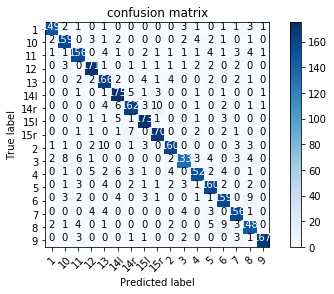

Normalized confusion matrix
[[0.91 0.01 0.01 0.   0.01 0.   0.   0.   0.   0.   0.02 0.01 0.   0.01
  0.01 0.02 0.01]
 [0.01 0.9  0.   0.02 0.01 0.01 0.   0.   0.   0.   0.01 0.02 0.01 0.01
  0.   0.01 0.  ]
 [0.01 0.01 0.86 0.   0.02 0.01 0.   0.01 0.01 0.01 0.01 0.01 0.02 0.01
  0.02 0.02 0.01]
 [0.   0.02 0.   0.92 0.01 0.   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.
  0.01 0.   0.  ]
 [0.   0.   0.01 0.01 0.89 0.01 0.   0.02 0.01 0.02 0.   0.   0.01 0.
  0.01 0.01 0.  ]
 [0.   0.   0.01 0.   0.01 0.93 0.03 0.01 0.02 0.   0.   0.01 0.   0.01
  0.   0.   0.01]
 [0.   0.   0.   0.   0.02 0.03 0.85 0.02 0.05 0.   0.   0.01 0.   0.01
  0.   0.01 0.01]
 [0.   0.   0.   0.01 0.01 0.03 0.01 0.93 0.01 0.   0.   0.01 0.   0.02
  0.   0.   0.  ]
 [0.   0.   0.01 0.01 0.   0.01 0.04 0.   0.92 0.   0.   0.01 0.   0.01
  0.01 0.   0.  ]
 [0.01 0.01 0.   0.01 0.05 0.   0.01 0.02 0.   0.87 0.   0.   0.   0.
  0.02 0.02 0.  ]
 [0.01 0.05 0.04 0.01 0.   0.   0.   0.   0.   0.01 0.8  0.02 0.02 0.
  0.02 0

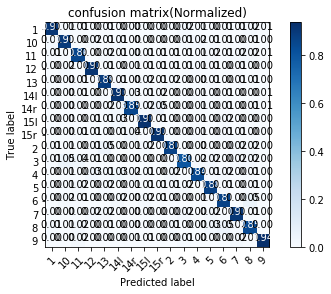

In [19]:
def get_predict(model,X):

    array_p=model.predict([X])
    predict=[np.argmax(i) for i in array_p]
    return  np.array(predict)

prd = get_predict(model,X_test)
pr.confuse_matrix_plot(y_test,prd,encoder.classes_,title="confusion matrix")

In [20]:
from keras.models import model_from_json

In [23]:
# serialize model to JSON
model_json = model.to_json()
with open("model/model_pyther.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model/model_pyther.h5")
print("Saved model to disk")


Saved model to disk
